In [1]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to hande undersampled data
# and how to write a simple iterative reconstruction algorithm with
# the acquisition model.
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of March 2019
# Author: Johannes Mayer
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.




In [2]:
__version__ = '0.1.0'

# import engine module
import pGadgetron as pMR

# import further modules
import os, numpy, copy
%matplotlib 
import matplotlib.pyplot as plt
%matplotlib 

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg


In [3]:
#%% GO TO MR FOLDER
os.chdir(pMR.petmr_data_path('mr'))

In [4]:
# We'll use this function to norm the 
def norm_array( arr ):
    min_a = abs(arr).min()
    max_a = abs(arr).max()
    
    return (arr - min_a)/(max_a - min_a)
    

### Time to get warmed up again:
Since we deal with undersampled data in this last section, we need to compare it to a reference.
So we need to reconstruct the fully sampled dataset we encountered before.

This is an ideal opprotunity to test what we learned and employ the `pMR.FullSampledReconstructor` class from before.

### Programming Task: Fully sampled reconstruction

__Hint:__ As always: the `Tab` key is your friend and autosuggestion tool!

__Please write code that does the following:__
- create a variable called `full_acq_data` of type `pMR.AcquisitionData` from the file simulated_MR_2D_cartesian.h5
- create a variable called `pp_full_acq_data` and assign it the preprocessed data by calling the function `pMR.preprocess_acquisition_data` on our variable `full_acq_data`
- create a variable called `recon` of type `pMR.FullySampledReconstructor()`
- call the `set_input` method of `recon` on `pp_full_acq_data` to assign our fully sampled dataset to our reconstructor
- call the `process()` method of `recon` without arguments (but don't forget the brackets!)
- create a variable called `fs_image` and assign it the output of the `get_output` method of `recon`

#### Don't look at the solution before you tried! 
Cells to run:
- Skip `#Solution Cell` if you want to see if your code works and run #Validation Cell instead.
- If it fails, run `#Solution Cell` instead and then `#Validation Cell` afterwards. Then you are up to date again.


In [5]:
# Solution Cell



































full_acq_data = pMR.AcquisitionData('simulated_MR_2D_cartesian.h5')
pp_full_acq_data = pMR.preprocess_acquisition_data( full_acq_data )

recon = pMR.FullySampledReconstructor()
recon.set_input( pp_full_acq_data )
recon.process()
fs_image = recon.get_output()

(-0.5, 255.5, 255.5, -0.5)

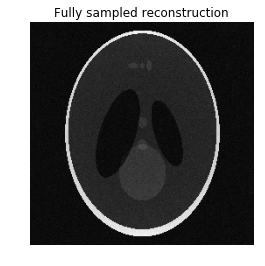

In [6]:
# VALIDATION CELL
fs_image_array = fs_image.as_array()
fs_image_array = norm_array(fs_image_array)

plt.close()
fig = plt.figure()
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully sampled reconstruction')
ax.axis('off')

In [7]:
def our_fft( k_array ):
    image_array = numpy.zeros(k_array.shape, numpy.complex128)
    for c in range(num_channels):
        image_array[:,c,:] = numpy.fft.fftshift( numpy.fft.ifft2( numpy.fft.ifftshift(k_array[:,c,:])))
#     image_array = image_array/image_array.max()    
    image_array = numpy.sum( image_array, 1)
    return image_array

In [8]:
# LOADING AND PREPROCESSING DATA FOR THIS SET
acq_data = pMR.AcquisitionData('simulated_MR_2D_cartesian_Grappa2.h5')
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)

In [9]:
# LET'S GET SOME INFORMATION FROM THE DATA
print('Is the data we loaded sorted? %s' % preprocessed_data.is_sorted())
print('Is the data we loaded undersampled? %s' % preprocessed_data.is_undersampled())

Is the data we loaded sorted? False
Is the data we loaded undersampled? 1


In [10]:
# OK SO LET'S SORT IT THEN
preprocessed_data.sort()
print('Is the data we loaded sorted? %s' % preprocessed_data.is_sorted())

Is the data we loaded sorted? True


In [11]:
#%% RETRIEVE K-SPACE DATA
k_array = preprocessed_data.as_array()
print('Size of k-space %dx%dx%d' % k_array.shape)

Size of k-space 160x8x256


Size of k-space 160x8x256


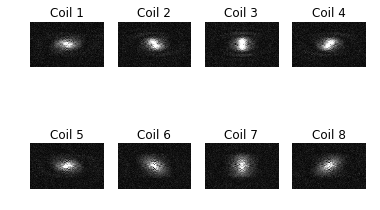

In [12]:
#%% SELECT VIEW DATA FROM DIFFERENT COILS
print('Size of k-space %dx%dx%d' % k_array.shape)

num_channels = k_array.shape[1]


plt.close()
fig = plt.figure(1)
plt.set_cmap('gray')
for c in range(num_channels):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(k_array[:,c,:]), vmin=0, vmax=1)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')


This looks pretty similar to what we had before.

(-0.5, 255.5, 255.5, -0.5)

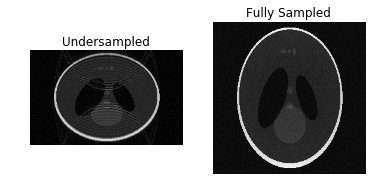

In [13]:
# now we make a FFT of the data we looked at and compare it to our fully sampled image
image_array_sos = our_fft( k_array )
image_array_sos = norm_array(image_array_sos)


plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(image_array_sos), vmin=0, vmax=1)
ax.set_title('Undersampled')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully Sampled')
ax.axis('off')


### Question: 
Please answer the following question for yourself:
- What differences appear between the two reconstructions?
- What artifacts appear in the Undersampled reconstruction?
- Why is the undersampled reconstruction clinched, but contains the whole image?
- We found that our dataset is undersampled. What parts of k-space do you expect to be missing?

In [14]:
# NOW LET'S LOOK WHICH PARTS ARE SAMPLED AND WHICH ARE LEFT OUT
which_ro = preprocessed_data.get_info('kspace_encode_step_1')
sampling_mask = numpy.zeros([256,256])

for ro in which_ro:
    sampling_mask[ro,:] = 1

    

(-0.5, 255.5, 255.5, -0.5)

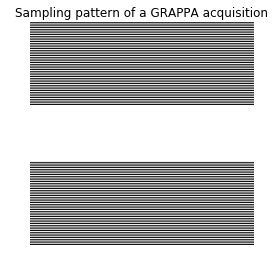

In [15]:
# PLOT THE SAMPLING MASK    
plt.close()
fig = plt.figure(1)
plt.set_cmap('gray')
ax = fig.add_subplot(1,1,1)
ax.imshow( sampling_mask, vmin=0, vmax=1)
ax.set_title('Sampling pattern of a GRAPPA acquisition')
ax.axis('off')

We notice that $160 = \frac{256}{2} + 32$.
This means the around the center of k-space is densely sampled containing 64 readout lines.
The outside of k-space is undersampled by a factor of 2.

### Workaround: 'zero-fill' the k-space data
Since the shape of the data seems to be the problem, let's just change that shape into the one we want.

But can we just add datapoints? This will corrupt the data!

Actually, a Fourier transform is just a sum weighted by a phase. 

So it does not mind if we add zeros to it!

This means we make a larger array, add our data in the correct spots, and the gaps we fill with zeros. The correct spots are given by our sampling mask!

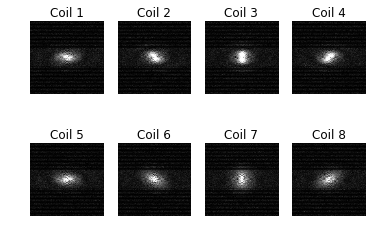

In [16]:
k_shape = [sampling_mask.shape[0], num_channels, sampling_mask.shape[1]]
zf_k_array = numpy.zeros(k_shape, numpy.complex128)

for i in range(k_array.shape[0]):
    zf_k_array[which_ro[i],:,:] = k_array[i,:,:]


plt.close()
fig = plt.figure()
plt.set_cmap('gray')
for c in range(num_channels):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(zf_k_array[:,c,:]), vmin=0, vmax=1)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
    
    
    

(-0.5, 255.5, 255.5, -0.5)

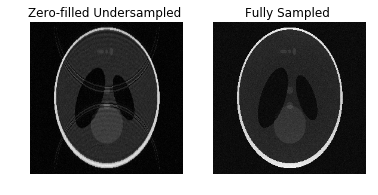

In [17]:
# Reconstruct the zero-filled data and take a look
zf_recon = our_fft( zf_k_array)
zf_recon = norm_array(zf_recon)

plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('Zero-filled Undersampled ')
ax.axis('off')


ax = fig.add_subplot(1,2,2)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully Sampled ')
ax.axis('off')


### Observation: 
Bummer. Now the shape is correct, however the artifacts are still present. To get rid of these we will need some parallel imaging techniques.


### Coilmap computation
On the topic of parallel imaging, this has something to do with exploiting the spatially varying coil sensitivities.  
So we should probably look at them.


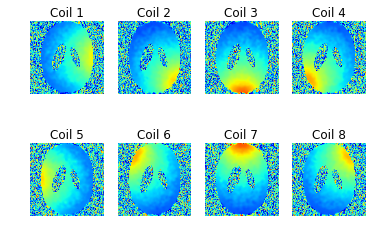

In [18]:
# WHICH COILMAPS DO WE GET FROM THIS DATASET?
csm = pMR.CoilSensitivityData()
csm.smoothness = 40
csm.calculate(preprocessed_data)
csm_array = numpy.squeeze(csm.as_array(0))

csm_array = csm_array.transpose([1,0,2])

plt.close()
fig = plt.figure()
plt.set_cmap('jet')
for c in range(csm_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
plt.set_cmap('gray')

### Question: 
Why is it not important in estimating coilmaps, that
- we have only a fully sampled  k-space center?
- there are artifacts in the reconstruction? Why are they not in the coilmaps?

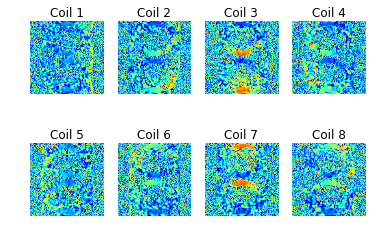

In [19]:
# WHAT WOULD HAVE HAPPENED IF WE DIDN'T ACQUIRE THE CENTER?

zf_k_array[0:2:,:,:] = 0


preprocessed_data.fill( zf_k_array )
csm.calculate(preprocessed_data)

csm_array = numpy.squeeze(csm.as_array(0))

csm_array = csm_array.transpose([1,0,2])

plt.close()
fig = plt.figure()
plt.set_cmap('jet')
for c in range(csm_array.shape[1]):
    ax = fig.add_subplot(2,4,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
plt.set_cmap('gray')

# FILL ORIGINAL DAYA WITH CENTER BACK INTO OUR CONTAINER
preprocessed_data.fill(k_array)
csm.calculate(preprocessed_data)


In [20]:
# NOW DO A GRAPPA RECONSTRUCTION

recon = pMR.CartesianGRAPPAReconstructor()
recon.set_input(preprocessed_data)
recon.compute_gfactors(False)
print('---\n reconstructing...')

recon.process()
# for undersampled acquisition data GRAPPA computes Gfactor images
# in addition to reconstructed ones
grappa_images = recon.get_output()
grappa_images_array = grappa_images.as_array()
grappa_images_array = norm_array(grappa_images_array)

---
 reconstructing...


(-0.5, 255.5, 255.5, -0.5)

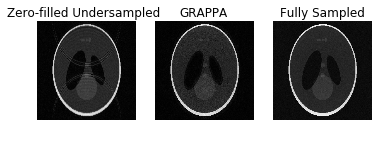

In [21]:
# PLOT THE RESULTS
plt.close()
fig = plt.figure()

ax = fig.add_subplot(1,3,1)
ax.imshow(abs(zf_recon), vmin=0, vmax=1)
ax.set_title('Zero-filled Undersampled ')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(abs(grappa_images_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('GRAPPA')
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(abs(fs_image_array[0,:,:]), vmin=0, vmax=1)
ax.set_title('Fully Sampled')
ax.axis('off')

### Question:
Well, that was very little code to perform a difficult task! That is because we sent our data off to The Gadgetron and they did all the work.

In what respect did a GRAPPA reconstruction:

 * improve the resulting image?
 * deterioate the resulting image?
 * why is there more noise in the GRAPPA reconstruction?

# GREAT! Now we want to develop our own algorithm and be better than the GRAPPA reconstruction!
## Urgh, let's rather not because we are so annoyed at how much code we have to write all the time!
### Enter: AcquisitionModel

We want to capture our entire imaging and reconstruction process in one single object and don't care about data structure. Also we don't want to have to sum over coil channels all the time and take care of zero filling, this is just too much work!  

In SIRF there exists something called AcquisitionModel, in the literature also referenced as and Encoding operator $E$, E for encoding.

For an image $x$, we want to be able to go __forward__ into k-space
$$ E: x \rightarrow y $$
implicitly performing multiplication of the image with the coil sensitivities $C_c$ for each channel $c$ and performing an FFT:

$$
E x = y_c = \mathcal{F}( C_c \cdot x) 
$$

For given k-space data, we want to __backward__ into image space, doing the zero-filling, inverse FFT, and coil combination as one single operation:
$$ E^H: y \rightarrow x $$
, implicitly performing everything:  
$$
E^H y = x =  \frac{\sum_c C_c^*\mathcal{F}^{-1}(y) }{\sum_c C_c^*C_c}
$$



In [22]:
# NOW WE GENERATE THE E OPERATOR FROM ABOVE AND ASSIGN OUR COIL SENSITIVITIES
E = pMR.AcquisitionModel(preprocessed_data, grappa_images)
E.set_coil_sensitivity_maps(csm)

# Now we can hop back from k-space to image space in just one line:
aq_model_image = E.backward( preprocessed_data )
aq_model_image_array = aq_model_image.as_array()



Well this is not much code any more. Suddenly implementing an iterative algorithm seems feasible
### QUESTION
BEFORE YOU RUN THE NEXT CELL AND LOOK AT THE PLOT:
In the next plot the image stored in `aq_model_image_array` will be shown, i.e. $x = E^H y$.  
Based on the discussion what the AcquisitionModel E does, what do you expect the reconstruction to look like?
- Is it clinched or is it the correct size?
- Does it contain artifacts? If so, which ones?

(-0.5, 255.5, 255.5, -0.5)

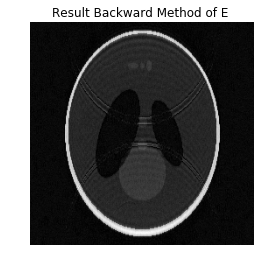

In [23]:
plt.set_cmap('gray')
fig = plt.figure(5)
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(aq_model_image_array[0,:,:]))
ax.set_title('Result Backward Method of E ')
ax.axis('off')

__Well, bummer again, the artifacts are still there!__ Of course, the acquisition model is just a compact version of our above code. We need something smarter to kill them off.

# Conjugate Gradient SENSE
## Iterative Parallel Imaging Reconstruction

In order to employ parallel imagaing, we should look at image reconstruction as an inverse problem.
By "image reconstruction" we actually mean to achieve the following equality:
$$ E x = y $$, or equivalently
$$ E^H E x = E^H y$$ 
where $E$ is the encoding operator $x$ is the true image object and $y$ is the MR raw data we acquired. 
The task of image reconstruction boils down to optimizing the following function:
$$ \mathcal{C}(x) = \frac{1}{2} \bigl{|} \bigl{|}  E x - y \bigr{|} \bigr{|}_2  \\
\tilde{x} = \min_x \mathcal{C}(x)
$$

## How to implement Conjugate Gradient Descent SENSE
Is that going to be better than a GRAPPA reconstruction? 
For that we need to write a bit of code:
- We already have this encoding operator `E` defined.
- Now we need to use it to iteratively optimize our cost function with a conjugate gradient descent optimization.

To this end we can study the corresponding [Wikipedia Article](https://en.wikipedia.org/wiki/Conjugate_gradient_method#Description_of_the_problem_addressed_by_conjugate_gradients).

This looks like our thang! We don't care too much about maths, but we want the [algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm).


They want to compute x in $Ax = b$, we want to compute x in $E^H E x = E^H y$.  
This means we need to translate what it says on Wikipedia:
- $A$ = $E^HE$
- $b$ = $E y$

### Programming task
Please write code executing the following task:
- define a fuction named `EhE`
- it should have one single argument `image`
- it should return $E^H( E (image))$  

__Hint 1:__ We defined `E` already. Use it's methods `forward` and `backward`. `forward` goes from image space to k-space and `backward` the other way round.  
__Hint 2:__ Short reminder on the syntax. The function should look like: 
```
def function_name( arugment_name):
    variable = code_that_does_something_with ( argument_name )
    return variable
```

In [24]:
# Write your code here (this is as much space as you need!)
# make sure the name of your function is EhE 





In [25]:
# Don't look at the solution before you tried! 


















































# We define a function to save some work
def EhE( image ):
    return E.backward( E.forward(image) )

#### Back to Wikipedia
Now we have all the tools we need. Now let's get back to Wikipedia.
We want the [algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm).

In [26]:
# our images should be the same shape as the GRAPPA outout
recon_img =  grappa_images 

# but we want to start from zero
zero_array = recon_img.as_array()
zero_array.fill(0)
recon_img.fill(zero_array)

# now name the variables the same as in the wikipedia article:
x = recon_img
y = preprocessed_data


### Programming task: Initialize Iterative Reconstruction
Please write code executing the following task:
- Initialize a variable `r` with `r` = $b - Ax$ (`r` stands for residual) If you forgot what $b$ and $A$ were in our context scroll back up!
- Print the type of `r` using Pythons `type()` function. What type do you expect? Is it an image, or is it acquisition data?
- After you wrote these two lines run your cell pressing `Ctrl+Enter`, to get the output of the print statement.
- Afterwards, initialize a variable named `rr` with `rr` = $r^\dagger r$. (`rr` stands for r times r)  
__Hint__: No need to access any numpy arrays! Objects of type `sirf.Gadgetron.ImageData` have the method called ` norm()` giving you the square root of the quanitity we are looking for. `rr` is the value of the cost funciton by the way.
- Initialize a variable `rr0` with the value of `rr` to store the starting norm of the residuals.

In [27]:
## WRITE YOUR CODE IN THIS CELL
## Please make sure to name the variables correctly




In [28]:
##### Don't look at the solution before you tried! #############################

















































############################################################################
# this is our first residual
r = E.backward( y ) - EhE(x)

# print the type
print('The type of r is: ' + str( type(r) ) ) 

# this is our cost function at the start
rr = r.norm() ** 2
rr0 = rr

# intialize p
p = r


The type of r is: <class 'sirf.Gadgetron.ImageData'>


In [29]:
# now we write down the algorithm

# how many iterative steps do we want
# how low should the cost be
num_iter = 10
sufficiently_small = 1e-6

In [30]:
print('Cost for k = 0: '  + str( rr/ rr0) )
for k in range(num_iter):
    
    Ap = EhE( p )
       
    alpha = rr / numpy.sum( (numpy.conj(p.as_array())) * Ap.as_array() ) 
    
    x = x + alpha * p
    r = r - alpha * Ap
    
    beta  = r.norm()**2 / rr
    rr = r.norm()**2
    
    p = r + beta * p
    
    print('Cost for k = ' +str(k+1) + ': ' + str( rr/ rr0) )
    if( rr/rr0 < sufficiently_small ):
        print( 'We achieved our desired accuracy. Stopping iterative reconstruction' )
        break
    

Cost for k = 0: 1.0
Cost for k = 1: 0.00277152640147
Cost for k = 2: 0.000708539991108
Cost for k = 3: 0.000243983993991
Cost for k = 4: 9.68398083395e-05
Cost for k = 5: 1.78589315044e-05
Cost for k = 6: 4.22900163506e-06
Cost for k = 7: 9.35641085666e-07
We achieved our desired accuracy. Stopping iterative reconstruction


(-0.5, 255.5, 255.5, -0.5)

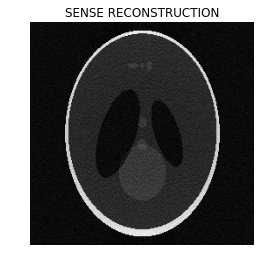

In [33]:

recon_arr = norm_array( x.as_array())

plt.set_cmap('gray')
fig = plt.figure(5)
ax = fig.add_subplot(1,1,1)
ax.imshow(abs(recon_arr[0,:,:]))
ax.set_title('SENSE RECONSTRUCTION')
ax.axis('off')

(-0.5, 255.5, 255.5, -0.5)

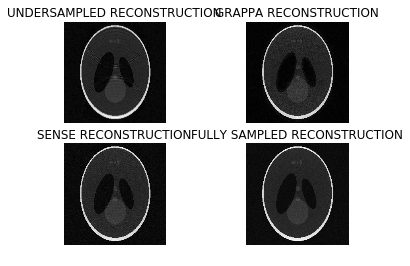

In [32]:
# Let's Plot
recon_arr = x.as_array()

plt.close()
fig = plt.figure()

ax = fig.add_subplot(2,2,1)
ax.imshow(abs(aq_model_image_array[0,:,:]))
ax.set_title('UNDERSAMPLED RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,2)
ax.imshow(abs(grappa_images_array[0,:,:]))
ax.set_title('GRAPPA RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,3)
ax.imshow(abs(recon_arr[0,:,:]))
ax.set_title('SENSE RECONSTRUCTION')
ax.axis('off')

ax = fig.add_subplot(2,2,4)
ax.imshow(abs(fs_image_array[0,:,:]))
ax.set_title('FULLY SAMPLED RECONSTRUCTION')
ax.axis('off')



And if you had typed this into your computer in 2001 and written a [paper](https://scholar.google.de/scholar?hl=de&as_sdt=0%2C5&q=Advances+in+sensitivity+encoding+with+arbitrary+k%E2%80%90space+trajectories&btnG=) on it, then 18 years later you had 1000 citations (plus 5992 citations from the [previous one](https://scholar.google.de/scholar?hl=de&as_sdt=0%2C5&q=SENSE%3A+sensitivity+encoding+for+fast+MRI&btnG=)).

